# Explainable AI using Lime and SHAP

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d74d55ed72aefa0ad36c98fdc070c4e2c0e378cfac1ee20f30d847cdcd487a4f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# from lime import lime_image
from skimage.segmentation import mark_boundaries
# from grad_cam import GradCAM  # Ensure you have a GradCAM implementation

In [ ]:
data_path = "/content/data"

image_paths = os.listdir(data_path)
image_paths_new = []
for path in image_paths:
  new_path = os.path.join(data_path, path)
  image_paths_new.append(new_path)

image_paths_new

['/content/data/1_n03445924_golfcart.png',
 '/content/data/8_n03938244_pillow.png',
 '/content/data/7_n04146614_school_bus.png',
 '/content/data/10_n02966193_carousel.png',
 '/content/data/9_n03344393_fireboat.png',
 '/content/data/2_n04557648_water_bottle.png',
 '/content/data/5_n03180011_desktop_computer.JPEG',
 '/content/data/imagenet_class_index.json',
 '/content/data/6_n02391049_zebra.png',
 '/content/data/3_n03661043_library.png',
 '/content/data/4_n02965783_car_mirror.JPEG']

In [ ]:
image_paths_new.remove('/content/data/imagenet_class_index.json')

In [ ]:
image_paths_new

['/content/data/1_n03445924_golfcart.png',
 '/content/data/8_n03938244_pillow.png',
 '/content/data/7_n04146614_school_bus.png',
 '/content/data/10_n02966193_carousel.png',
 '/content/data/9_n03344393_fireboat.png',
 '/content/data/2_n04557648_water_bottle.png',
 '/content/data/5_n03180011_desktop_computer.JPEG',
 '/content/data/6_n02391049_zebra.png',
 '/content/data/3_n03661043_library.png',
 '/content/data/4_n02965783_car_mirror.JPEG']

In [ ]:
#!/usr/bin/env python3

# ============================
# Description: Grad-CAM Example Code for Multiple Models
# Author: Lin Zhi (Modified by Your Name)
# Date: 20 Nov 2023
# ============================

import torch
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from PIL import Image
import json
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Allow duplicate lib
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

device = "cuda" if torch.cuda.is_available() else "cpu"
as_numpy = lambda x: x.detach().cpu().numpy()

# Define colormap
jet = matplotlib.cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]

def plot_result(ax, img, saliency, label="", save_path=None):
    img = np.array(img, dtype=float) / 255.0
    saliency = F.interpolate(saliency, size=img.shape[:2], mode="bilinear")
    saliency = as_numpy(saliency)[0, 0]
    saliency = saliency - saliency.min()
    saliency = np.uint8(255 * saliency / saliency.max())
    heatmap = jet_colors[saliency]
    superimposed_img = heatmap * 0.4 + img
    ax.imshow(superimposed_img)
    ax.axis("off")
    ax.set_title(label)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

# Preprocessing transform
image_shape = (224, 224)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Load ImageNet class index
def load_class_index(json_path="data/imagenet_class_index.json"):
    with open(json_path) as f:
        indx2label = json.load(f)
    return indx2label

indx2label = load_class_index()

def decode_predictions(preds, k=5):
    # return the top k results in the predictions
    return [
        [(*indx2label[str(i)], i, pred[i]) for i in pred.argsort()[::-1][:k]]
        for pred in as_numpy(preds)
    ]

# Probe class for hooking
class Probe:
    def get_hook(self):
        self.data = []
        def hook(module, input, output):
            self.data.append(output)
        return hook

# Function to generate Grad-CAM
def generate_gradcam(model, layer, input_tensor, target_class):
    probe = Probe()
    handle = layer.register_forward_hook(probe.get_hook())

    logits = model(input_tensor)
    preds = F.softmax(logits, dim=1)

    # Backward pass for the target class
    model.zero_grad()
    target = logits[0, target_class]
    target.backward(retain_graph=True)

    # Get gradients from the target layer
    last_conv_output = probe.data[0]
    last_conv_output.retain_grad()
    grad = last_conv_output.grad  # [1, C, H, W]

    # Compute weights
    weights = grad.mean(dim=(2,3), keepdim=True)  # global average pooling

    # Compute saliency map
    saliency = torch.sum(last_conv_output * weights, dim=1, keepdim=True)  # weighted sum
    saliency = F.relu(saliency)  # ReLU activation

    handle.remove()

    return saliency

# Load and preprocess image
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)  # [1, C, H, W]
    return input_tensor, img

# Main function to perform Grad-CAM
def perform_gradcam(model, model_name, layer, image_path, top_n=3):
    input_tensor, img = load_image(image_path)

    # Forward pass
    logits = model(input_tensor)
    preds = F.softmax(logits, dim=1)

    # Decode predictions
    predictions = decode_predictions(preds, k=top_n)[0]
    print(f"\nPrediction results for {model_name}:")
    for tag, label, i, prob in predictions:
        print(f"{tag} {label:16} {i:5} {prob:6.2%}")

    # Generate Grad-CAM for top-N predictions
    saliency_maps = []
    for idx, (tag, label, class_idx, prob) in enumerate(predictions):
        print(f"Generating Grad-CAM for class: {label}")
        saliency = generate_gradcam(model, layer, input_tensor, class_idx)
        saliency_maps.append((label, saliency))

    # Plot and save results
    fig, axes = plt.subplots(1, top_n, figsize=(8*top_n, 8))
    if top_n == 1:
        axes = [axes]

    for i, (label, saliency) in enumerate(saliency_maps):
        save_path = f"explanations/gradcam_{model_name}_{label}.png"
        plot_result(axes[i], img, saliency, f"Grad-CAM: {model_name} on {label}", save_path=save_path)

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Ensure explanations directory exists
    os.makedirs("explanations", exist_ok=True)

    # Models to analyze
    models_to_use = [
        {"name": "resnet50", "model": models.resnet50(pretrained=True).to(device), "layer": models.resnet50(pretrained=True).layer4},
        {"name": "vgg16", "model": models.vgg16(pretrained=True).to(device), "layer": models.vgg16(pretrained=True).features[28]},
    ]

    # Replace with your image paths
    # data_path = "/content/data"
    image_paths = image_paths_new

    for model_info in models_to_use:
        model_name = model_info["name"]
        model = model_info["model"]
        layer = model_info["layer"]

        print(f"\nProcessing with {model_name}...")

        # Process each image
        for image_path in image_paths:
            print(f"\nImage: {image_path}")
            perform_gradcam(model, model_name, layer, image_path, top_n=3)

<ipython-input-11-c82f51a9ef91>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = matplotlib.cm.get_cmap("jet")



Processing with resnet50...

Image: /content/data/1_n03445924_golfcart.png

Prediction results for resnet50:
n03532672 hook               600  0.67%
n02909870 bucket             463  0.61%
n03970156 plunger            731  0.53%
Generating Grad-CAM for class: hook


IndexError: list index out of range

In [ ]:
#!/usr/bin/env python3

import torch
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from PIL import Image
import json
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = "cuda" if torch.cuda.is_available() else "cpu"
as_numpy = lambda x: x.detach().cpu().numpy()

# Set up colormap
jet = matplotlib.colormaps["jet"]
jet_colors = jet(np.arange(256))[:, :3]

def plot_result(ax, img, saliency, label=""):
    img = np.array(img, dtype=float) / 255.0
    saliency = F.interpolate(saliency, size=img.shape[:2], mode="bilinear")
    saliency = as_numpy(saliency)[0, 0]
    saliency = saliency - saliency.min()
    saliency = np.uint8(255 * saliency / saliency.max())
    heatmap = jet_colors[saliency]
    ax.imshow(0.5 * heatmap + 0.5 * img)
    ax.axis("off")
    ax.set_title(label)

# Image preprocessing
image_shape = (224, 224)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Load ImageNet labels
with open("data/imagenet_class_index.json") as f:
    indx2label = json.load(f)

def decode_predictions(preds, k=5):
    return [
        [(*indx2label[str(i)], i, pred[i]) for i in pred.argsort()[::-1][:k]]
        for pred in as_numpy(preds)
    ]

class Probe:
    def get_hook(self):
        self.data = []
        def hook(module, input, output):
            self.data.append(output)
        return hook

# Load models
model1 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model2 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

model1.eval()
model2.eval()
model1.to(device)
model2.to(device)

# List of test images
image_files = image_paths_new

def generate_gradcam(model, img, probe, is_vgg=False):
    x = transform(img)[None].to(device)

    # Clear previous data
    probe.data = []

    logits = model(x)
    preds = logits.softmax(-1)

    results = []
    N = 2  # Top-2 predictions
    targets = preds.argsort(descending=True)[0, :N]

    for target in targets:
        target = target.item()
        last_conv_output = probe.data[0]
        last_conv_output.retain_grad()

        logits[0, target].backward(retain_graph=True)
        grad = last_conv_output.grad
        weight = grad.mean(dim=(-1, -2), keepdim=True)
        saliency = (last_conv_output * weight).sum(dim=1, keepdim=True)
        saliency = saliency.clamp(min=0)
        last_conv_output.grad.data.zero_()

        results.append((saliency, target))

    return results, preds

# Process each image
for img_path in image_files:
    print(f"\nProcessing {img_path}...")
    img = Image.open(img_path).convert("RGB")

    # Set up figure
    plt.figure(figsize=(15, 10))

    # ResNet50
    probe1 = Probe()
    handle1 = model1.layer4.register_forward_hook(probe1.get_hook())
    results1, preds1 = generate_gradcam(model1, img, probe1)

    # VGG16
    probe2 = Probe()
    handle2 = model2.features[-1].register_forward_hook(probe2.get_hook())
    results2, preds2 = generate_gradcam(model2, img, probe2, is_vgg=True)

    # Get prediction scores
    resnet_preds = decode_predictions(preds1)[0]
    vgg_preds = decode_predictions(preds2)[0]

    # Plot results
    plt.subplot(2, 2, 1)
    plot_result(plt.gca(), img, results1[0][0],
               f"ResNet50 - Top 1: {indx2label[str(results1[0][1])][1]}")

    plt.subplot(2, 2, 2)
    plot_result(plt.gca(), img, results1[1][0],
               f"ResNet50 - Top 2: {indx2label[str(results1[1][1])][1]}")

    plt.subplot(2, 2, 3)
    plot_result(plt.gca(), img, results2[0][0],
               f"VGG16 - Top 1: {indx2label[str(results2[0][1])][1]}")

    plt.subplot(2, 2, 4)
    plot_result(plt.gca(), img, results2[1][0],
               f"VGG16 - Top 2: {indx2label[str(results2[1][1])][1]}")

    plt.suptitle(f"Grad-CAM Visualization - {os.path.basename(img_path)}")
    plt.tight_layout()
    plt.savefig(f"gradcam_{os.path.basename(img_path)}.png")
    plt.close()

    # Print detailed predictions to console
    print(f"\nResults for {os.path.basename(img_path)}:")
    print("\nResNet50 Top-5 Predictions:")
    for tag, label, idx, prob in resnet_preds:
        print(f"{label}: {prob:.2%}")

    print("\nVGG16 Top-5 Predictions:")
    for tag, label, idx, prob in vgg_preds:
        print(f"{label}: {prob:.2%}")

    # Clean up
    handle1.remove()
    handle2.remove()

print("Processing complete!")


Processing /content/data/1_n03445924_golfcart.png...

Results for 1_n03445924_golfcart.png:

ResNet50 Top-5 Predictions:
golfcart: 75.33%
swing: 0.34%
horizontal_bar: 0.14%
water_jug: 0.13%
laptop: 0.13%

VGG16 Top-5 Predictions:
golfcart: 98.50%
barrow: 0.60%
swing: 0.40%
motor_scooter: 0.17%
park_bench: 0.03%

Processing /content/data/8_n03938244_pillow.png...

Results for 8_n03938244_pillow.png:

ResNet50 Top-5 Predictions:
pillow: 36.26%
sliding_door: 0.29%
bonnet: 0.25%
velvet: 0.19%
sleeping_bag: 0.18%

VGG16 Top-5 Predictions:
pillow: 100.00%
quilt: 0.00%
wallet: 0.00%
purse: 0.00%
handkerchief: 0.00%

Processing /content/data/7_n04146614_school_bus.png...

Results for 7_n04146614_school_bus.png:

ResNet50 Top-5 Predictions:
school_bus: 45.64%
freight_car: 0.11%
crane: 0.10%
passenger_car: 0.10%
Angora: 0.09%

VGG16 Top-5 Predictions:
school_bus: 100.00%
passenger_car: 0.00%
minibus: 0.00%
trolleybus: 0.00%
cab: 0.00%

Processing /content/data/10_n02966193_carousel.png...

Resu

## LIME

GPU Info:
Loading ResNet50 model...

Processing /content/data/1_n03445924_golfcart.png...
Generating LIME explanation (this may take a few minutes)...


  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation generated in 14.12 seconds
Error processing /content/data/1_n03445924_golfcart.png: operands could not be broadcast together with shapes (375,500) (375,500,3) (375,500) 

Processing /content/data/8_n03938244_pillow.png...
Generating LIME explanation (this may take a few minutes)...


  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation generated in 20.31 seconds
Error processing /content/data/8_n03938244_pillow.png: operands could not be broadcast together with shapes (500,500) (500,500,3) (500,500) 

Processing /content/data/7_n04146614_school_bus.png...
Generating LIME explanation (this may take a few minutes)...


  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation generated in 14.28 seconds
Error processing /content/data/7_n04146614_school_bus.png: operands could not be broadcast together with shapes (376,500) (376,500,3) (376,500) 

Processing /content/data/10_n02966193_carousel.png...
Generating LIME explanation (this may take a few minutes)...


  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation generated in 13.92 seconds
Error processing /content/data/10_n02966193_carousel.png: operands could not be broadcast together with shapes (375,500) (375,500,3) (375,500) 

Processing /content/data/9_n03344393_fireboat.png...
Generating LIME explanation (this may take a few minutes)...


  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation generated in 13.29 seconds
Error processing /content/data/9_n03344393_fireboat.png: operands could not be broadcast together with shapes (375,500) (375,500,3) (375,500) 

Processing /content/data/2_n04557648_water_bottle.png...
Generating LIME explanation (this may take a few minutes)...


  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation generated in 13.85 seconds
Error processing /content/data/2_n04557648_water_bottle.png: operands could not be broadcast together with shapes (500,375) (500,375,3) (500,375) 

Processing /content/data/5_n03180011_desktop_computer.JPEG...
Generating LIME explanation (this may take a few minutes)...


  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation generated in 13.32 seconds
Error processing /content/data/5_n03180011_desktop_computer.JPEG: operands could not be broadcast together with shapes (375,500) (375,500,3) (375,500) 

Processing /content/data/6_n02391049_zebra.png...
Generating LIME explanation (this may take a few minutes)...


  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation generated in 12.08 seconds
Error processing /content/data/6_n02391049_zebra.png: operands could not be broadcast together with shapes (333,500) (333,500,3) (333,500) 

Processing /content/data/3_n03661043_library.png...
Generating LIME explanation (this may take a few minutes)...


  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation generated in 12.20 seconds
Error processing /content/data/3_n03661043_library.png: operands could not be broadcast together with shapes (333,500) (333,500,3) (333,500) 

Processing /content/data/4_n02965783_car_mirror.JPEG...
Generating LIME explanation (this may take a few minutes)...


  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation generated in 15.19 seconds
Error processing /content/data/4_n02965783_car_mirror.JPEG: operands could not be broadcast together with shapes (409,500) (409,500,3) (409,500) 

Processing complete!


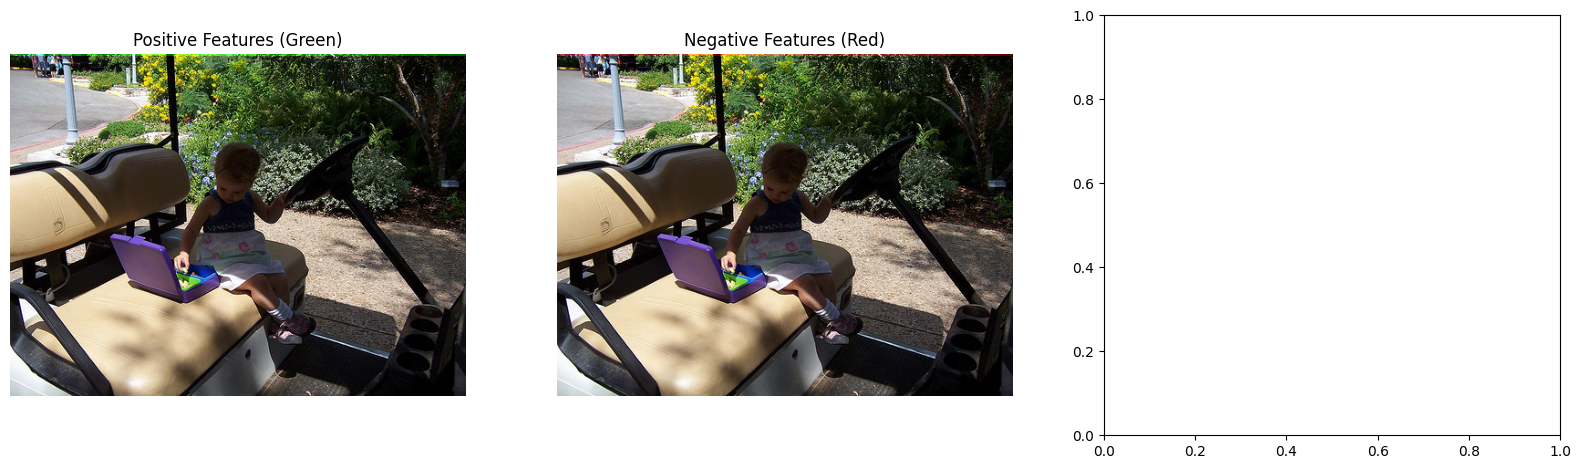

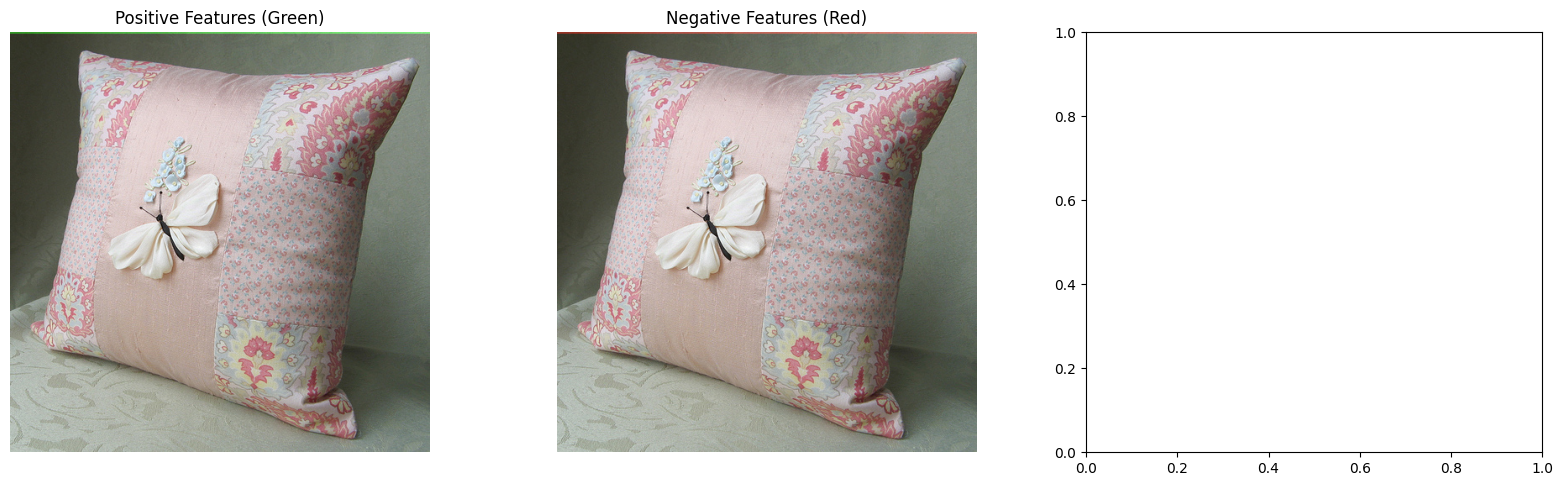

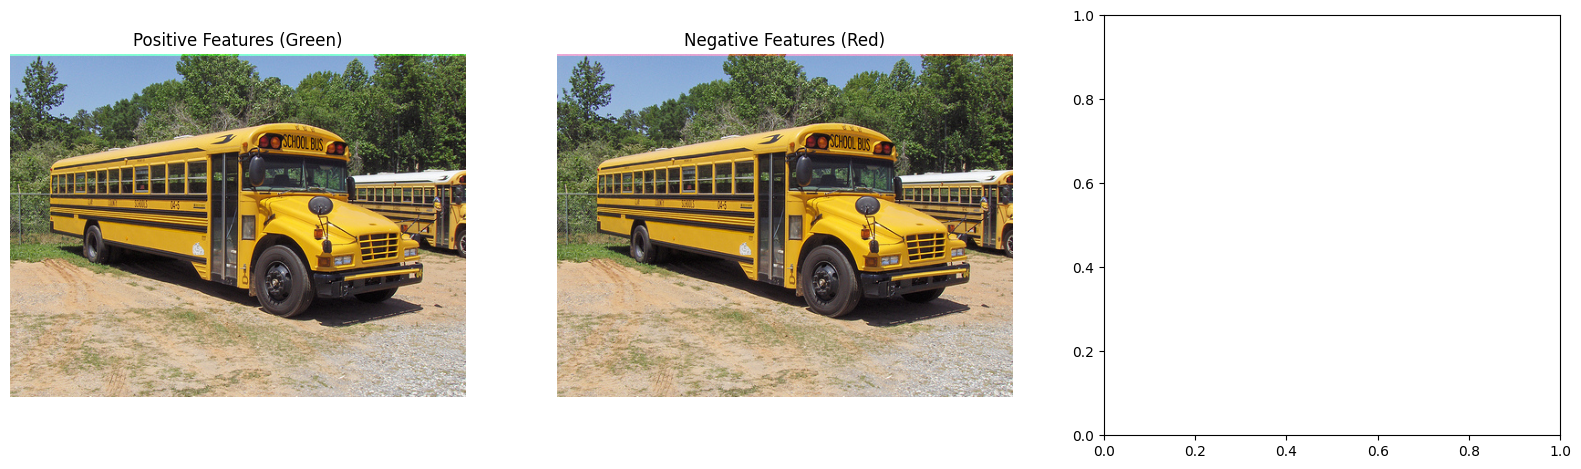

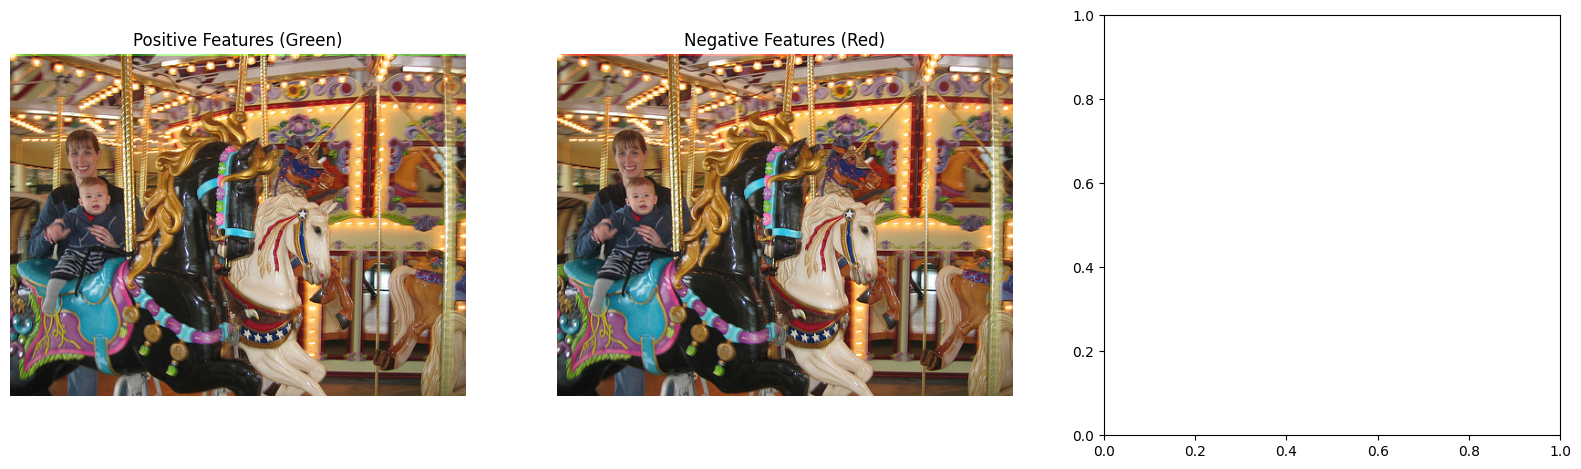

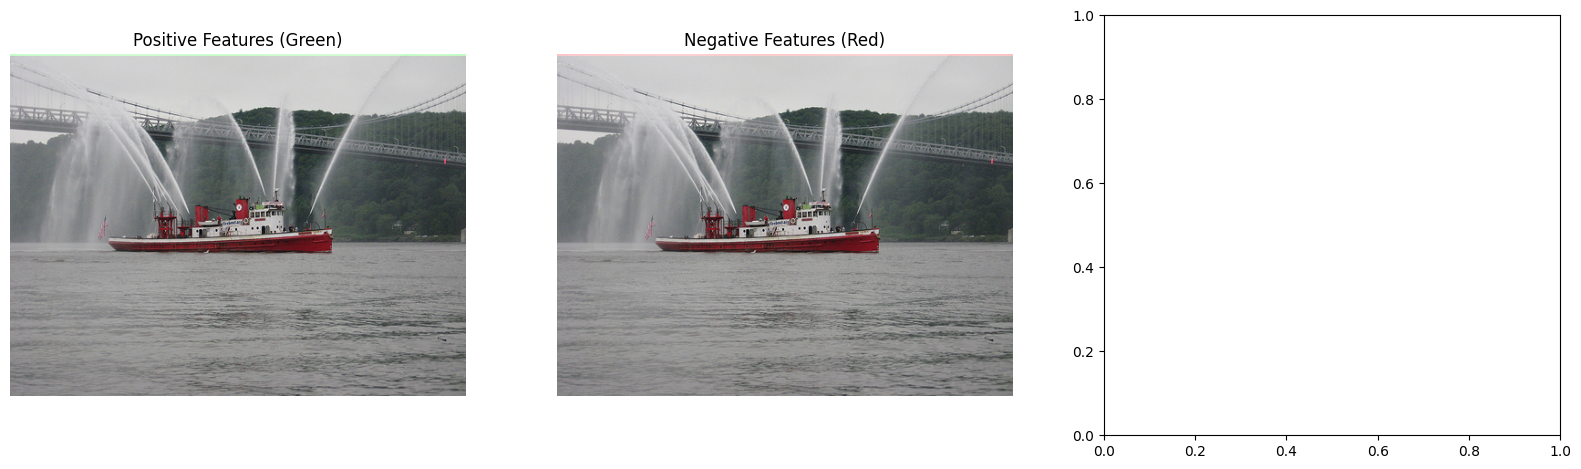

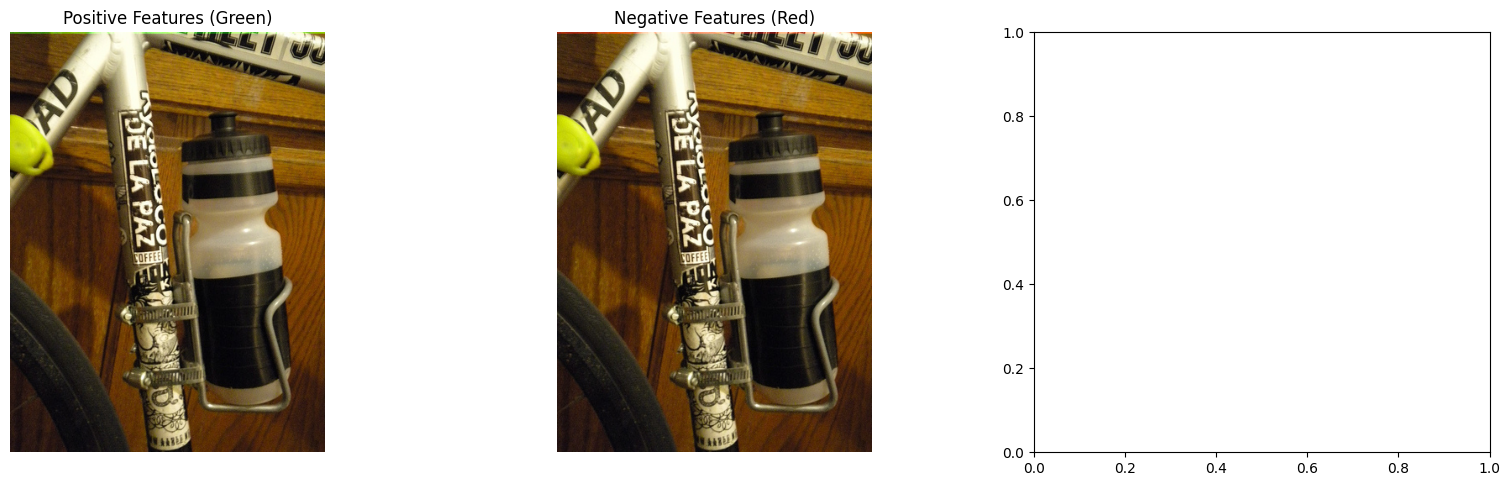

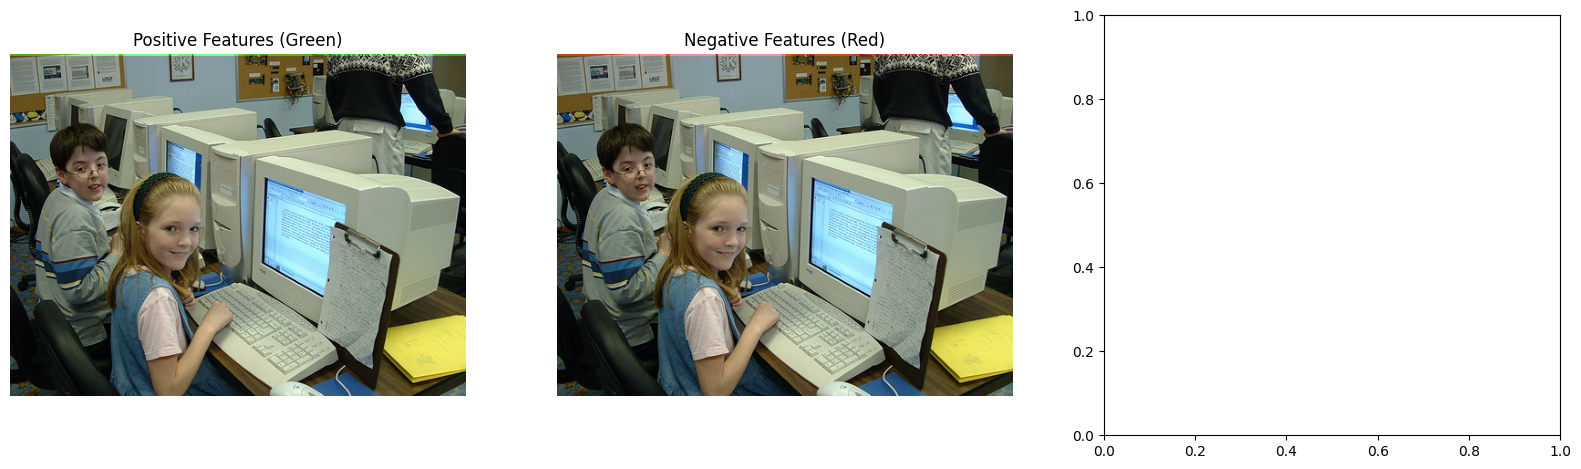

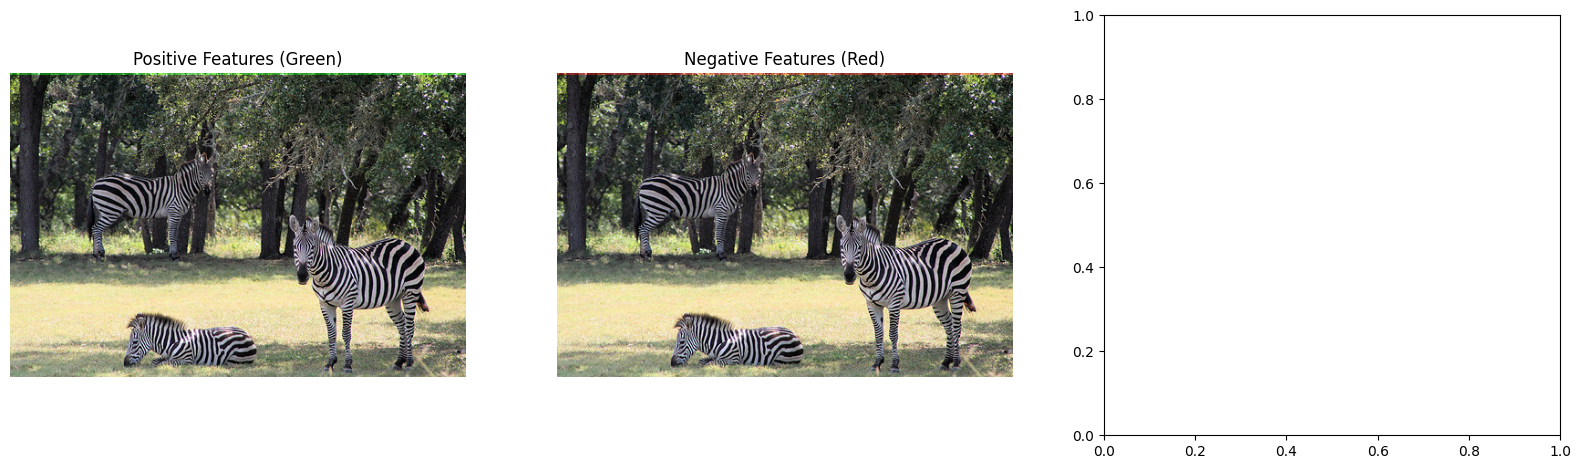

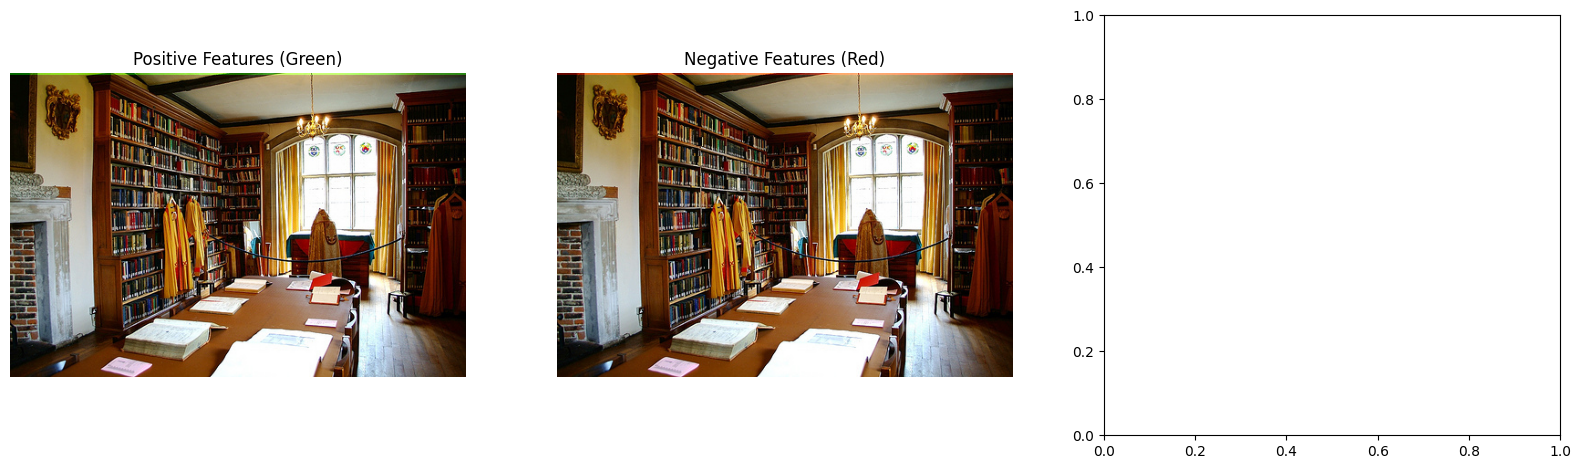

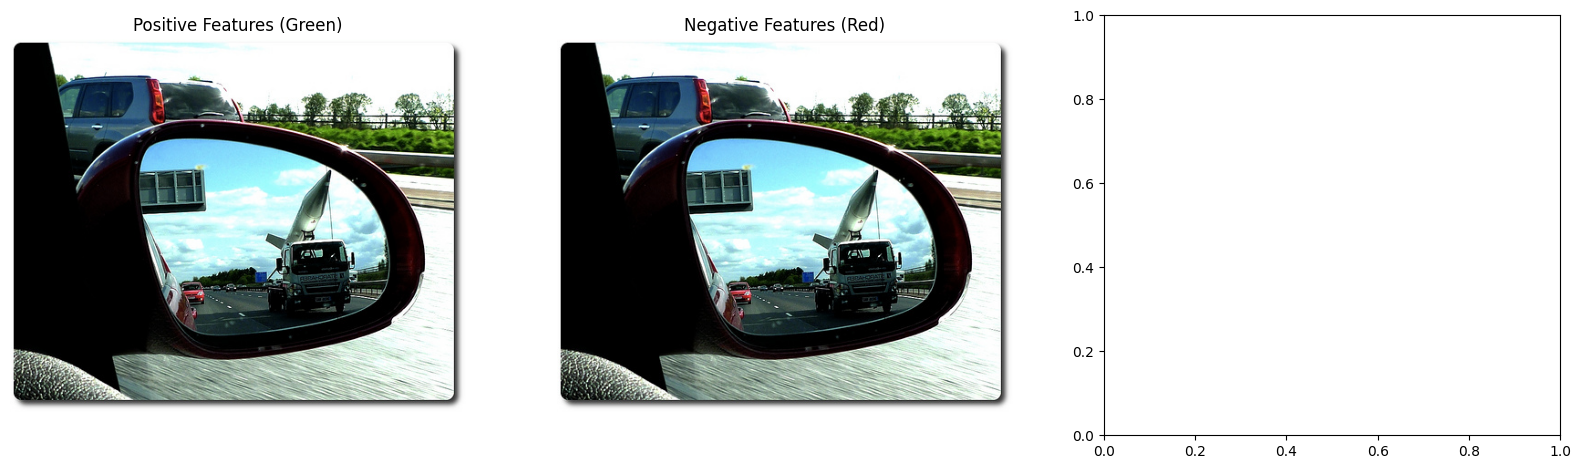

In [ ]:
#!/usr/bin/env python3

import torch
import torchvision
import torchvision.models as models
from PIL import Image
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import time
import gc

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Limit GPU memory usage
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.7)

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = "cuda" if torch.cuda.is_available() else "cpu"
as_numpy = lambda x: x.detach().cpu().numpy()

# Print GPU info
if torch.cuda.is_available():
    print("GPU Info:")
    os.system('nvidia-smi')

# Image preprocessing
image_shape = (128, 128)  # Reduced image size
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Load ImageNet labels
with open("data/imagenet_class_index.json") as f:
    indx2label = json.load(f)

def apply_overlay(image, mask, positive=True):
    """Apply green (positive) or red (negative) overlay on the image"""
    overlay = image.copy()
    if positive:
        overlay[mask] = np.clip(overlay[mask] + np.array([0, 100, 0]), 0, 255)  # Green overlay
    else:
        overlay[mask] = np.clip(overlay[mask] + np.array([100, 0, 0]), 0, 255)  # Red overlay
    return overlay

def decode_predictions(preds, k=5):
    return [
        [(*indx2label[str(i)], i, pred[i]) for i in pred.argsort()[::-1][:k]]
        for pred in as_numpy(preds)
    ]

def get_lime_predictor(model):
    def predict_fn(images):
        batch_size = 4
        predictions = []

        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]
            batch = torch.stack([transform(Image.fromarray(img)) for img in batch_images])
            batch = batch.to(device)
            with torch.no_grad():
                logits = model(batch)
                probs = logits.softmax(-1)
            predictions.append(as_numpy(probs))

            del batch, logits, probs
            torch.cuda.empty_cache()

        return np.concatenate(predictions, axis=0)
    return predict_fn

def generate_lime_explanation(model, img_array, explainer, top_k=5):
    predict_fn = get_lime_predictor(model)

    print("Generating LIME explanation (this may take a few minutes)...")
    start_time = time.time()

    explanation = explainer.explain_instance(
        img_array,
        predict_fn,
        top_labels=top_k,
        hide_color=0,
        num_samples=500
    )

    print(f"LIME explanation generated in {time.time() - start_time:.2f} seconds")
    return explanation

def plot_predictions(ax, predictions, title):
    ax.axis('off')
    text = f"{title}\n\n"
    for tag, label, idx, prob in predictions[:5]:
        text += f"{label}: {prob:.2%}\n"
    ax.text(0.1, 0.9, text, fontsize=10, va='top')

def process_single_image(img_path, model):
    print(f"\nProcessing {img_path}...")

    # Clear memory before processing
    torch.cuda.empty_cache()
    gc.collect()

    try:
        # Load and preprocess image
        img = Image.open(img_path).convert("RGB")
        img_array = np.array(img)

        # Get model predictions
        with torch.no_grad():
            x = transform(img)[None].to(device)
            preds = model(x).softmax(-1)
            predictions = decode_predictions(preds)[0]

        del x, preds
        torch.cuda.empty_cache()

        # Initialize LIME explainer
        explainer = lime_image.LimeImageExplainer()

        # Generate LIME explanation
        lime_explanation = generate_lime_explanation(model, img_array, explainer)

        # Create visualization
        plt.figure(figsize=(20, 12))

        top_class = predictions[0][2]

        # Original image with positive features (green)
        plt.subplot(2, 3, 1)
        temp, mask = lime_explanation.get_image_and_mask(
            top_class, positive_only=True, num_features=5, hide_rest=False)
        enhanced_img = apply_overlay(img_array, mask, positive=True)
        plt.imshow(enhanced_img)
        plt.axis('off')
        plt.title("Positive Features (Green)")

        # Original image with negative features (red)
        plt.subplot(2, 3, 2)
        temp, mask = lime_explanation.get_image_and_mask(
            top_class, positive_only=False, negative_only=True, num_features=5, hide_rest=False)
        enhanced_img = apply_overlay(img_array, mask, positive=False)
        plt.imshow(enhanced_img)
        plt.axis('off')
        plt.title("Negative Features (Red)")

        # Combined visualization on original image
        plt.subplot(2, 3, 3)
        temp, mask = lime_explanation.get_image_and_mask(
            top_class, positive_only=False, num_features=10, hide_rest=False)

        # Separate positive and negative masks
        explanation = lime_explanation.local_exp[top_class]
        positive_mask = np.zeros(mask.shape, dtype=bool)
        negative_mask = np.zeros(mask.shape, dtype=bool)

        for feature, weight in explanation:
            if weight > 0:
                positive_mask |= (temp == feature)
            else:
                negative_mask |= (temp == feature)

        # Apply both overlays
        enhanced_img = img_array.copy()
        enhanced_img = apply_overlay(enhanced_img, positive_mask, positive=True)
        enhanced_img = apply_overlay(enhanced_img, negative_mask, positive=False)

        plt.imshow(enhanced_img)
        plt.axis('off')
        plt.title("Combined Features (Green: Pros, Red: Cons)")

        # Original image for comparison
        plt.subplot(2, 3, 4)
        plt.imshow(img_array)
        plt.axis('off')
        plt.title("Original Image")

        # Heatmap visualization
        plt.subplot(2, 3, 5)
        explanation = lime_explanation.local_exp[top_class]
        weights = np.zeros(temp.shape)
        for feature, weight in explanation:
            weights[temp == feature] = weight

        plt.imshow(img_array)
        plt.imshow(weights, cmap='RdYlGn', alpha=0.5)
        plt.axis('off')
        plt.title("Feature Importance Heatmap")

        # Predictions
        plt.subplot(2, 3, 6)
        plot_predictions(plt.gca(), predictions, f"{model.__class__.__name__} Predictions")

        plt.suptitle(f"LIME Explanations - {os.path.basename(img_path)}", fontsize=16)
        plt.tight_layout()

        # Save with higher DPI for better quality
        plt.savefig(f"lime_{model.__class__.__name__.lower()}_{os.path.basename(img_path)}",
                   dpi=300, bbox_inches='tight')
        plt.close()

        # Print predictions
        print(f"\nResults for {os.path.basename(img_path)}:")
        for tag, label, idx, prob in predictions:
            print(f"{label}: {prob:.2%}")

        # Clear memory
        del lime_explanation, img, img_array
        torch.cuda.empty_cache()
        gc.collect()

    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")

def main():
    try:
        # Load ResNet50 model
        print("Loading ResNet50 model...")
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        model.eval()
        model.to(device)

        # List of test images
        image_files = image_paths_new

        # Process each image
        for img_path in image_files:
            process_single_image(img_path, model)

        print("\nProcessing complete!")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

    finally:
        # Clean up
        torch.cuda.empty_cache()
        gc.collect()

if __name__ == "__main__":
    main()